In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
from numba import jit

In [12]:
# initialize parameters
rate = {'lambda0' : 10.0,
        'lambda1' : 10.0,
        'lambda2' : 8.0,
        'lambda3' : 12.0,
        'omega' : 1.0,
        'broken' : 0.15,
        'phi' : 1.0,
        'car_move' : 1.0,
        #'delta' : 1.0,
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [[0.1, 0.2, 0.3, 0.4],
       [0.2, 0.1, 0.3, 0.4],
       [0.3, 0.2, 0.1, 0.4],
       [0.4, 0.2, 0.3, 0.1],]



  0%|                                                  | 0/200 [00:00<?, ?it/s]

  0%|▏                                         | 1/200 [00:10<33:26, 10.08s/it]

  1%|▍                                         | 2/200 [00:21<34:26, 10.44s/it]

  2%|▋                                         | 3/200 [00:33<36:13, 11.04s/it]

  2%|▊                                         | 4/200 [00:47<38:19, 11.73s/it]

  2%|█                                         | 5/200 [01:02<41:15, 12.69s/it]

  3%|█▎                                        | 6/200 [01:18<44:10, 13.66s/it]

  4%|█▍                                        | 7/200 [01:35<47:42, 14.83s/it]

  4%|█▋                                        | 8/200 [01:53<50:12, 15.69s/it]

  4%|█▉                                        | 9/200 [02:12<53:17, 16.74s/it]

  5%|██                                       | 10/200 [02:32<56:06, 17.72s/it]

  6%|██▎                                      | 11/200 [02:53<58:38, 18.62s/it]

  6%|██▎                  

 50%|██████████████████▏                 | 101/200 [1:17:35<1:37:07, 58.87s/it]

 51%|██████████████████▎                 | 102/200 [1:18:33<1:36:00, 58.78s/it]

 52%|██████████████████▌                 | 103/200 [1:19:32<1:34:52, 58.68s/it]

 52%|██████████████████▋                 | 104/200 [1:20:30<1:33:43, 58.58s/it]

 52%|██████████████████▉                 | 105/200 [1:21:29<1:32:39, 58.52s/it]

 53%|███████████████████                 | 106/200 [1:22:28<1:32:01, 58.74s/it]

 54%|███████████████████▎                | 107/200 [1:23:26<1:30:52, 58.63s/it]

 54%|███████████████████▍                | 108/200 [1:24:25<1:29:48, 58.57s/it]

 55%|███████████████████▌                | 109/200 [1:25:23<1:28:49, 58.57s/it]

 55%|███████████████████▊                | 110/200 [1:26:22<1:27:52, 58.58s/it]

 56%|███████████████████▉                | 111/200 [1:27:21<1:27:04, 58.70s/it]

 56%|████████████████████▏               | 112/200 [1:28:19<1:25:59, 58.63s/it]

 56%|████████████████████▎  

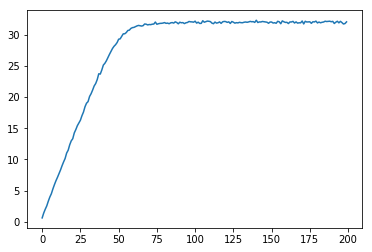

In [14]:
#the influence of phi
#the collection is no longer a queue
#but a car moving among areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.capacity = 10
        #self.W = [0]*4
        self.F = 0
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))
        self.served_customers = 0

#         self.reset()

    def reset(self):
        self.T = 0
        self.served_customers = 0
        #self.W = [0]*4
        #self.F = [0]*4
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, dummy parameter]
        heapq.heappush(self.scheduler, [0, 0, 0, 0])
        return self.state + [self.T]

    def simulate(self):
        with open('C:/Rebalancing/data/simulationResult/central/data/distributed_0.15_phi.csv', 'w') as fout:
            writer = csv.writer(fout)
            writer.writerow(self.reset())
            while self.T <= self.time_limit:
                writer.writerow(self.step())
        return self.served_customers/(self.T-10000)
        
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A*3 + self.A*s + t
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0:
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
                heapq.heappop(self.scheduler)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[int(start[1])+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[self.A*2+terminal] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
            else:
                event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, 0]
                heapq.heappush(self.scheduler, event) 
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>10000: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 0
run_time = 20000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
#%time env.simulate()
result = []
for i in tqdm(range(1, 201)):
    env.R['phi'] = i*0.1
    env.R['omega'] += env.R['phi']
    result.append(env.simulate())

plt.plot(result)
plt.show()

In [15]:
with open('C:/Rebalancing/data/simulationResult/central/data/distributed_0.15_phi_parameters.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(rate)
    writer.writerow(rate.values())
    writer.writerow(pij)
    writer.writerow([N,A])
    writer.writerow([0.1*i for i in range(1,51)])
    writer.writerow(result)

In [16]:
with open('C:/Rebalancing/data/simulationResult/central/data/distributed_0.15_phi_result.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(result)

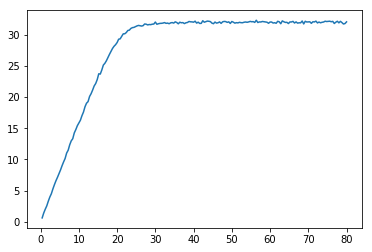

In [17]:
plt.plot([0.4*i for i in list(range(1,201))], result)
plt.savefig('C:/Rebalancing/data/simulationResult/distributed/graph/distributed_0.15_phi_fig.png')